# Herbivory Model
This is an alternative implementation meant to reduce memory demands by saving results once calculated and releasing RAM, thus only two time steps need to be in memory at any given point.

In [68]:
import numpy as np
import proplot as pplt

from tqdm import tqdm

In [120]:
# Model Parameters
T = 50         # Length of season
alpha = 0.2    # Strength of diminishing returns of proportion of production devoted to defense
G = 0.06      # Rate of production of new biomass per unit vegatative biomass
R = 0       # Background herbivory rate per unit biomass
K = 3.5        # Rate of decrease in herbviory as proportion of defense increases
save_dir = 'Example3'  # Name of directory to save intermediate results

def dC_dt(C, D, a):
    return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C

def dD_dt(C, D, a):
    return G*C*(a-alpha*a**2) - R*np.exp(-K*D/(C+D))*D

In [121]:
# Solver Parameters
# Define numerical bounds for space domain
Cmin = 0
Cmax =  120
Cnum = 600
h_C = (Cmax - Cmin) / (Cnum-1)
CC = np.linspace(Cmin, Cmax, Cnum).reshape(-1, 1)

Dmin = 0
Dmax = 120
Dnum = 600
h_D = (Dmax - Dmin) / (Dnum-1)
DD = np.linspace(Dmin, Dmax, Dnum)

# Define the 'proportions'
xx = DD / (CC + DD)
xx[0, 0] = 0

# Calculate numerical bounds for time domain based on CFL conditions
## Divide state discretization step by maximum possible speed to get an upper bound on the time step
tau = 1 / ((G*Cmax/h_C) + (G*(1-alpha)*Cmax/h_D))
## Calculate the number of steps (+1 to ensure tau < tau_max)
tnum = int(np.ceil(T / tau) + 1)
## Recalculate the time discretization step
tau = T / (tnum - 1)
tt = np.linspace(0, T, tnum)

# Define numerical bounds for the control space
amin = 0
amax = 1 
anum = 20
aa = np.linspace(amin, amax, anum)
#A = -amin*np.ones((tnum, Cnum, Dnum))

# Initialize solutions for best value
big_num = 1_000_000        # A placeholder for infinity to ensure proper computations
U_future = -big_num*np.ones((Cnum, Dnum)) # Initialize so ANY initial trajectory is accepted
U_future[:] = CC # Final time step is initialized with exit costs

print(tnum)

3236


C:\Users\camer\AppData\Local\Temp\ipykernel_13836\1536303156.py:16: RuntimeWarning: invalid value encountered in divide
  xx = DD / (CC + DD)


In [122]:
# Start at the final time, and calulate in reverse
with tqdm(total=tnum-2) as pbar:
    for n in range(tnum-2, -1, -1):
        # Set code up for vectorization
        t = tt[n]
        U_future_left = np.vstack(([[-big_num]*Dnum], U_future[:-1, :]))
        U_future_right = np.vstack((U_future[1:, :], [[-big_num]*Dnum]))
        U_future_down = np.hstack(([[-big_num]]*(Cnum), U_future[:, :-1]))
        U_future_up = np.hstack((U_future[:, 1:], [[-big_num]]*(Cnum)))
        BestVal = -np.inf * np.ones((CC.size, DD.size))
        #BestA = (amin-1) * np.ones((CC.size, DD.size))

        for a in aa: # Test every possible control value to determine best one for each point
            dCC = dC_dt(CC, DD, a)
            dCC[0,0] = 0
            dDD = dD_dt(CC, DD, a)
            dDD[0,0] = 0
            shift_C = tau * dCC
            shift_D = tau * dDD

            # Sanity check, CFL should be satisfied
            assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)

            # Determine direction (left/right and up/down that a point should be moving towards)
            dir_left = (shift_C < 0)
            dir_left[0, :] = 0 # Cannot move out of region
            dir_left[-1, :] = 1 # Cannot move out of region
            dir_right = 1-dir_left
            dir_down = (shift_D < 0)
            dir_down[:, 0] = 0 # Cannot move out of region
            dir_down[:, -1] = 1 # Cannot move out of region
            dir_up = 1-dir_down
            # Domain should be 'invariant' as time marches forward (there is an artificial maximum introduced by computational limitations)
            assert((shift_C[0, :] >= 0).all())
            assert((shift_D[:, 0] >= 0).all())


            p_C = np.abs(shift_C)/h_C   # probability of traveling in C direction
            p_D = np.abs(shift_D)/h_D   # Probability of traveling in D direction
            p_this = 1 - p_C - p_D      # Probability of staying still

            Val = dir_left * (p_C * U_future_left) \
                + dir_right * (p_C * U_future_right) \
                + dir_up * (p_D * U_future_up) \
                + dir_down * (p_D * U_future_down) \
                + p_this * U_future

            new_best = (Val > BestVal)
            BestVal[new_best] = Val[new_best]
            #BestA[new_best] = a

        # Save previous layer and use newly calculated one for next iteration
        np.save(f'Simulations/{save_dir}/U_{n+1}.npy', U_future)
        U_future = BestVal
        #A[n, :] = BestA
        
        pbar.update(1)
        
# Save final layer
np.save(f'Simulations/{save_dir}/U_0.npy', U_future)

  0%|                                                                                         | 0/3234 [00:00<?, ?it/s]C:\Users\camer\AppData\Local\Temp\ipykernel_13836\2870455803.py:10: RuntimeWarning: invalid value encountered in divide
  return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C
C:\Users\camer\AppData\Local\Temp\ipykernel_13836\2870455803.py:13: RuntimeWarning: invalid value encountered in divide
  return G*C*(a-alpha*a**2) - R*np.exp(-K*D/(C+D))*D
C:\Users\camer\AppData\Local\Temp\ipykernel_13836\3827410310.py:22: RuntimeWarning: divide by zero encountered in divide
  assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)
3235it [16:58:45, 18.90s/it]                                                                                           


In [113]:
# Control synthesis - best choice based on interpolation of value function
def synthesis_2(C_initial, D_initial):
    C_current = C_initial
    C_traj2 = [C_current]
    
    D_current = D_initial
    D_traj2 = [D_current]
    a_traj2 = []
    with tqdm(total=tnum-2) as pbar:
        for n in range(1, tnum):
            t = tt[n]
        
            # Load next time layer
            U = np.load(f'Simulations/{save_dir}/U_{n}.npy')
        
            Best_value = -1
            Best_a = -1
            # Identify optimal control value
            for a in np.linspace(0, 1, 100):
                # Calculate new position using each control value
                C_new = C_current + tau*dC_dt(C_current, D_current, a)
                D_new = D_current + tau*dD_dt(C_current, D_current, a)
        
                # Identify C and D grid points around the new position
                i = np.where((CC - C_new)<0, np.inf, CC - C_new).argmin() - 1
                j = np.where((DD - D_new)<0, np.inf, DD - D_new).argmin() - 1
        
                # Use new position to bilinearly interpolate in U
                U_C_1 = ((CC[i+1] - C_new)/h_C) * U[i, j] + ((C_new - CC[i])/h_C) * U[i+1, j]
                U_C_2 = ((CC[i+1] - C_new)/h_C) * U[i, j+1] + ((C_new - CC[i])/h_C) * U[i+1, j+1]
                U_int = ((DD[j+1] - D_new)/h_D) * U_C_1 + ((D_new - DD[j])/h_D) * U_C_2
        
                if U_int > Best_value:
                    Best_value = U_int
                    Best_a = a
    
            # Use best control to update position
            C_current = C_current + tau*dC_dt(C_current, D_current, Best_a)
            D_current = D_current + tau*dD_dt(C_current, D_current, Best_a)
            C_traj2.append(C_current)
            D_traj2.append(D_current)
            a_traj2.append(Best_a)
            
            pbar.update(1)
    
    return C_traj2, D_traj2, a_traj2

C_traj_bl, D_traj_bl, a_traj_bl = synthesis_2(3, 0)

4313it [01:29, 48.28it/s]                                                                                              


In [114]:
from scipy.interpolate import RectBivariateSpline
# Control synthesis - best choice based on interpolation of value function
def synthesis_rbs(C_initial, D_initial):
    C_current = C_initial
    C_traj2 = [C_current]
    D_current = D_initial
    D_traj2 = [D_current]
    a_traj2 = []
    with tqdm(total=tnum-2) as pbar:
        for n in range(1, tnum):
            t = tt[n]
        
            # Load next time layer
            U = np.load(f'Simulations/{save_dir}/U_{n}.npy')
            Best_value = -1
            Best_a = -1
            
            # Create value interpolation
            spline = RectBivariateSpline(CC, DD, U, kx=3, ky=3)
            
            # Identify optimal control value
            for a in np.linspace(0, 1, 100):
                # Calculate new position using each control value
                C_new = C_current + tau*dC_dt(C_current, D_current, a)
                D_new = D_current + tau*dD_dt(C_current, D_current, a)
            
                U_int = spline.ev(C_new, D_new)
                
                if U_int > Best_value:
                    Best_value = U_int
                    Best_a = a
    
            # Use best control to update position
            C_current = C_current + tau*dC_dt(C_current, D_current, Best_a)
            D_current = D_current + tau*dD_dt(C_current, D_current, Best_a)
            C_traj2.append(C_current)
            D_traj2.append(D_current)
            a_traj2.append(Best_a)
            
            pbar.update(1)
    
    return C_traj2, D_traj2, a_traj2

C_traj_rbs, D_traj_rbs, a_traj_rbs = synthesis_rbs(3, 0)

4313it [02:28, 29.13it/s]                                                                                              


In [115]:
# Optimal control from Yamamura and Tsuji, 1995
C_current = 3
C_traj_sample = [C_current]
D_current = 0
D_traj_sample = [D_current]
a_traj_sample = []
#Optimal_Value = 0
x_opt = 1/K * np.log(K*R/G)
t_1 = x_opt / (G*(1-x_opt))
for n in range(1, tnum):
    t = tt[n]
    a=0
    if t < t_1:
        a = 1
    elif t < 30:
        a = x_opt
    else:
        a = 0
    #Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    C_current = C_current + tau*dC_dt(C_current, D_current, a)
    D_current = D_current + tau*dD_dt(C_current, D_current, a)
    C_traj_sample.append(C_current)
    D_traj_sample.append(D_current)
    a_traj_sample.append(a)

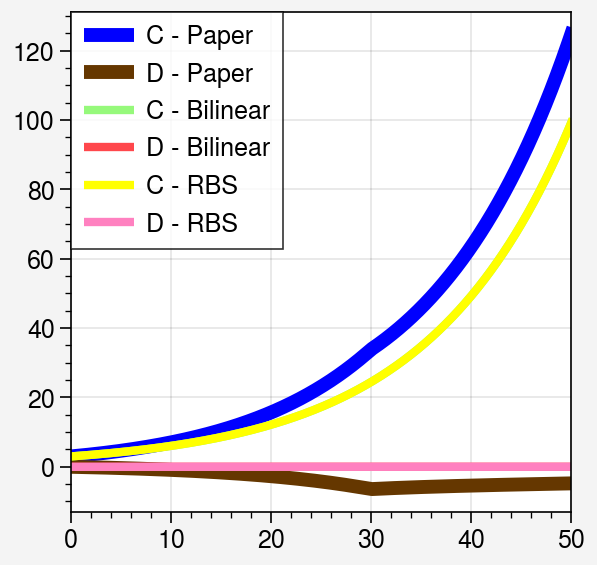

In [118]:
# Trajectories of C and D over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, C_traj_sample, color = 'blue', linewidth=5, label='C - Paper')
ax.plot(tt, D_traj_sample, color = 'brown', linewidth=5, label='D - Paper')
        
ax.plot(tt, C_traj_bl, color='light green', linewidth=3, label='C - Bilinear')
ax.plot(tt, D_traj_bl, color='light red', linewidth=3, label='D - Bilinear')     

ax.plot(tt, C_traj_rbs, color='yellow', linewidth=3, label='C - RBS')
ax.plot(tt, D_traj_rbs, color='pink', linewidth=3, label='D - RBS')    

ax.legend(loc='upper left', ncols=1)

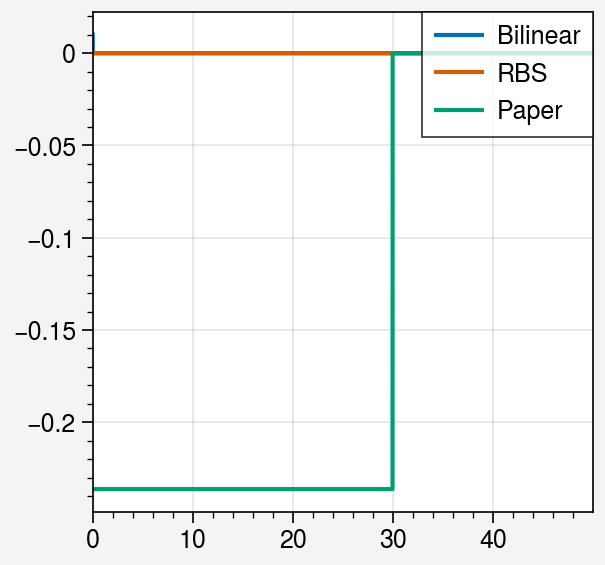

In [119]:
# Control function over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt[:-1], a_traj_bl, label='Bilinear')
ax.plot(tt[:-1], a_traj_rbs, label='RBS')
ax.plot(tt[:-1], a_traj_sample, label='Paper')

ax.legend(loc='upper right', ncols=1)

In [84]:
R = 0.10
def f(t):
    return np.exp(-t)
def F(t):
    return 1 - np.exp(-t)

In [85]:
# Define numerical bounds for the control space
bmin = 0
bmax = 1 
bnum = 20
bb = np.linspace(bmin, bmax, bnum)
B = -bmin*np.ones((tnum, Cnum, Dnum))

# Initialize solutions for best value and best control
big_num = 1_000_000        # A placeholder for infinity to ensure proper computations
V_future = -big_num*np.ones((Cnum, Dnum)) # Initialize so ANY initial trajectory is accepted
V_future[:] = CC # Final time step is initialized with exit costs

In [86]:
# Start at the final time, and calulate in reverse
with tqdm(total=tnum-2) as pbar:
    for n in range(tnum-2, -1, -1):
        # Set code up for vectorization
        t = tt[n]
        V_future_left = np.vstack(([[-big_num]*Dnum], V_future[:-1, :]))
        V_future_right = np.vstack((V_future[1:, :], [[-big_num]*Dnum]))
        V_future_down = np.hstack(([[-big_num]]*(Cnum), V_future[:, :-1]))
        V_future_up = np.hstack((V_future[:, 1:], [[-big_num]]*(Cnum)))
        BestVal = -np.inf * np.ones((CC.size, DD.size))
        #BestA = (amin-1) * np.ones((CC.size, DD.size))

        for a in aa: # Test every possible control value to determine best one for each point
            dCC = dC_dt(CC, DD, a)
            dCC[0,0] = 0
            dDD = dD_dt(CC, DD, a)
            dDD[0,0] = 0
            shift_C = tau * dCC
            shift_D = tau * dDD

            # Sanity check, CFL should be satisfied
            assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)

            # Determine direction (left/right and up/down that a point should be moving towards)
            dir_left = (shift_C < 0)
            dir_left[0, :] = 0 # Cannot move out of region
            dir_left[-1, :] = 1 # Cannot move out of region
            dir_right = 1-dir_left
            dir_down = (shift_D < 0)
            dir_down[:, 0] = 0 # Cannot move out of region
            dir_down[:, -1] = 1 # Cannot move out of region
            dir_up = 1-dir_down
            # Domain should be 'invariant' as time marches forward (there is an artificial maximum introduced by computational limitations)
            assert((shift_C[0, :] >= 0).all())
            assert((shift_D[:, 0] >= 0).all())


            p_C = np.abs(shift_C)/h_C   # probability of traveling in C direction
            p_D = np.abs(shift_D)/h_D   # Probability of traveling in D direction
            p_this = 1 - p_C - p_D      # Probability of staying still

            Val = dir_left * (p_C * U_future_left) \
                + dir_right * (p_C * U_future_right) \
                + dir_up * (p_D * U_future_up) \
                + dir_down * (p_D * U_future_down) \
                + p_this * U_future

            new_best = (Val > BestVal)
            BestVal[new_best] = Val[new_best]
            #BestA[new_best] = a
        
        # Update to include terminal penalties.
        U_future = np.load(f'Simulations/{save_dir}/U_{n+1}.npy')
        BestVal += f(t)*(U_future - V_future) / (1 - F(t)) 
        
        # Save previous layer and use newly calculated one for next iteration
        np.save(f'Simulations/{save_dir}/V_{n+1}.npy', V_future)
        V_future = BestVal
        #A[n, :] = BestA
        
        pbar.update(1)
        
# Save final layer
np.save(f'Simulations/{save_dir}/V_0.npy', V_future)

  0%|                                                                                         | 0/4312 [00:00<?, ?it/s]C:\Users\camer\AppData\Local\Temp\ipykernel_13836\2774277337.py:10: RuntimeWarning: invalid value encountered in divide
  return G*C*(1-a) - R*np.exp(-K*D/(C+D))*C
C:\Users\camer\AppData\Local\Temp\ipykernel_13836\2774277337.py:13: RuntimeWarning: invalid value encountered in divide
  return G*C*(a-alpha*a**2) - R*np.exp(-K*D/(C+D))*D
C:\Users\camer\AppData\Local\Temp\ipykernel_13836\3717459481.py:22: RuntimeWarning: divide by zero encountered in divide
  assert(np.sum(tau <= (h_C + h_D) / (np.abs(dCC) + np.abs(dDD))) == Cnum*Dnum)
C:\Users\camer\AppData\Local\Temp\ipykernel_13836\3717459481.py:54: RuntimeWarning: invalid value encountered in divide
  BestVal += f(t)*(U_future - V_future) / (1 - F(t))
4313it [2:54:16,  2.42s/it]                                                                                            


In [91]:
# Control synthesis - best choice based on interpolation of value function
def synthesis_2(C_initial, D_initial):
    C_current = C_initial
    C_traj2 = [C_current]
    
    D_current = D_initial
    D_traj2 = [D_current]
    a_traj2 = []
    with tqdm(total=tnum-2) as pbar:
        for n in range(1, tnum):
            t = tt[n]
        
            # Load next time layer
            V = np.load(f'Simulations/{save_dir}/V_{n}.npy')
        
            Best_value = 0
            Best_a = 0
            # Identify optimal control value
            for a in np.linspace(0, 1, 100):
                # Calculate new position using each control value
                C_new = C_current + tau*dC_dt(C_current, D_current, a)
                D_new = D_current + tau*dD_dt(C_current, D_current, a)
        
                # Identify C and D grid points around the new position
                i = np.where((CC - C_new)<0, np.inf, CC - C_new).argmin() - 1
                j = np.where((DD - D_new)<0, np.inf, DD - D_new).argmin() - 1
        
                # Use new position to bilinearly interpolate in U
                V_C_1 = ((CC[i+1] - C_new)/h_C) * V[i, j] + ((C_new - CC[i])/h_C) * V[i+1, j]
                V_C_2 = ((CC[i+1] - C_new)/h_C) * V[i, j+1] + ((C_new - CC[i])/h_C) * V[i+1, j+1]
                V_int = ((DD[j+1] - D_new)/h_D) * V_C_1 + ((D_new - DD[j])/h_D) * V_C_2
        
                if V_int > Best_value:
                    Best_value = V_int
                    Best_a = a
    
            # Use best control to update position
            C_current = C_current + tau*dC_dt(C_current, D_current, Best_a)
            D_current = D_current + tau*dD_dt(C_current, D_current, Best_a)
            C_traj2.append(C_current)
            D_traj2.append(D_current)
            a_traj2.append(Best_a)
            
            pbar.update(1)
    
    return C_traj2, D_traj2, a_traj2

C_traj_bl, D_traj_bl, a_traj_bl = synthesis_2(3, 0)

4313it [01:52, 38.40it/s]                                                                                              


In [92]:
from scipy.interpolate import RectBivariateSpline
# Control synthesis - best choice based on interpolation of value function
def synthesis_rbs(C_initial, D_initial):
    C_current = C_initial
    C_traj2 = [C_current]
    D_current = D_initial
    D_traj2 = [D_current]
    a_traj2 = []
    with tqdm(total=tnum-2) as pbar:
        for n in range(1, tnum):
            t = tt[n]
        
            # Load next time layer
            V = np.load(f'Simulations/{save_dir}/V_{n}.npy')
            Best_value = -1
            Best_a = -1
            
            # Create value interpolation
            spline = RectBivariateSpline(CC, DD, V, kx=3, ky=3)
            
            # Identify optimal control value
            for a in np.linspace(0, 1, 100):
                # Calculate new position using each control value
                C_new = C_current + tau*dC_dt(C_current, D_current, a)
                D_new = D_current + tau*dD_dt(C_current, D_current, a)
            
                V_int = spline.ev(C_new, D_new)
                
                if V_int > Best_value:
                    Best_value = V_int
                    Best_a = a
    
            # Use best control to update position
            C_current = C_current + tau*dC_dt(C_current, D_current, Best_a)
            D_current = D_current + tau*dD_dt(C_current, D_current, Best_a)
            C_traj2.append(C_current)
            D_traj2.append(D_current)
            a_traj2.append(Best_a)
            
            pbar.update(1)
    
    return C_traj2, D_traj2, a_traj2

C_traj_rbs, D_traj_rbs, a_traj_rbs = synthesis_rbs(3, 0)

4313it [05:43, 12.55it/s]                                                                                              


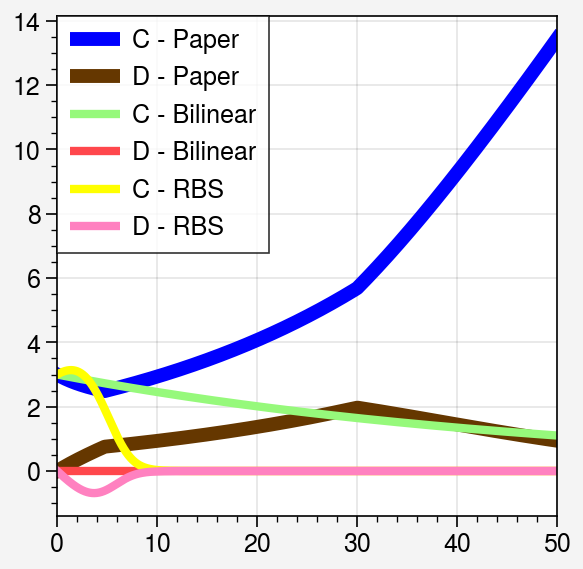

In [93]:
# Trajectories of C and D over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt, C_traj_sample, color = 'blue', linewidth=5, label='C - Paper')
ax.plot(tt, D_traj_sample, color = 'brown', linewidth=5, label='D - Paper')
        
ax.plot(tt, C_traj_bl, color='light green', linewidth=3, label='C - Bilinear')
ax.plot(tt, D_traj_bl, color='light red', linewidth=3, label='D - Bilinear')     

ax.plot(tt, C_traj_rbs, color='yellow', linewidth=3, label='C - RBS')
ax.plot(tt, D_traj_rbs, color='pink', linewidth=3, label='D - RBS')    

ax.legend(loc='upper left', ncols=1)

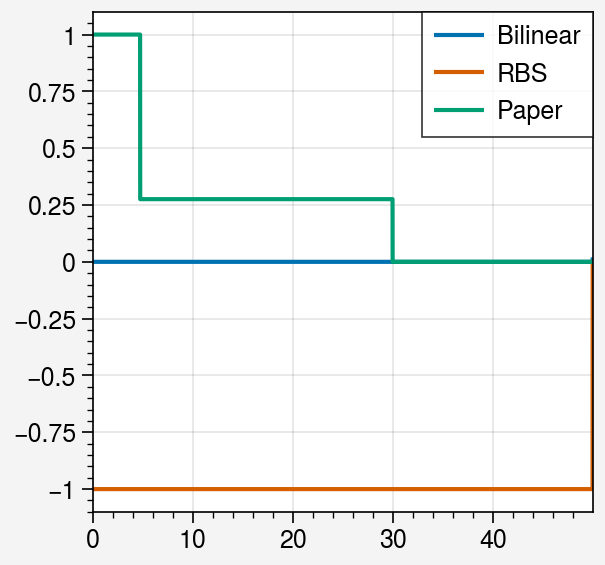

In [94]:
# Control function over time
fig, ax = pplt.subplots(nrows=1, ncols=1)

ax.plot(tt[:-1], a_traj_bl, label='Bilinear')
ax.plot(tt[:-1], a_traj_rbs, label='RBS')
ax.plot(tt[:-1], a_traj_sample, label='Paper')

ax.legend(loc='upper right', ncols=1)